# E2E_santander_pandas
This notebook is for **Archive Only.** Please **do not** expect it to run in the latest releases.  Cell output is saved and shown.  

Placed 17/8808. [Blog](https://medium.com/rapids-ai/financial-data-modeling-with-rapids-5bca466f348) 

In [1]:
import pandas as pd
import time
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

This notebook includes the best single model of Rapids.ai team for [Santander Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction/leaderboard). We placed **17/8808** in the competition.

### Reading CSV

In [2]:
%%time

PATH = '../input'
train_pd = pd.read_csv('%s/train.csv'%PATH)
print(train_pd.shape)

(200000, 202)
CPU times: user 4.81 s, sys: 524 ms, total: 5.33 s
Wall time: 5.33 s


### KDE for a single column

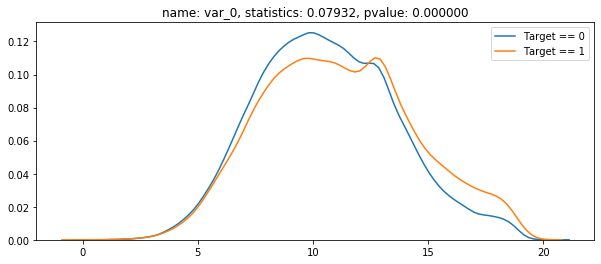

In [3]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = train_pd
target_mask = train['target'] == 1
non_target_mask = train['target'] == 0 
statistics_array = []
for col in train.columns[2:]:
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    statistics_array.append(statistic)
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.kdeplot(train.loc[non_target_mask, col], ax=ax, label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=ax, label='Target == 1')

    ax.set_title('name: {}, statistics: {:.5f}, pvalue: {:5f}'.format(col, statistic, pvalue))
    break

### Count encoding

In [4]:
%%time
for i in range(200):
    col = 'var_%d'%i
    var_count = train_pd.groupby(col).agg({col:'count'})
    var_count.columns = ['%s_count'%col]
    var_count = var_count.reset_index()
    train_pd = train_pd.merge(var_count,on=col,how='left')

CPU times: user 25min 20s, sys: 3min 58s, total: 29min 18s
Wall time: 2min 49s


### Visualizing patterns of count==1 group

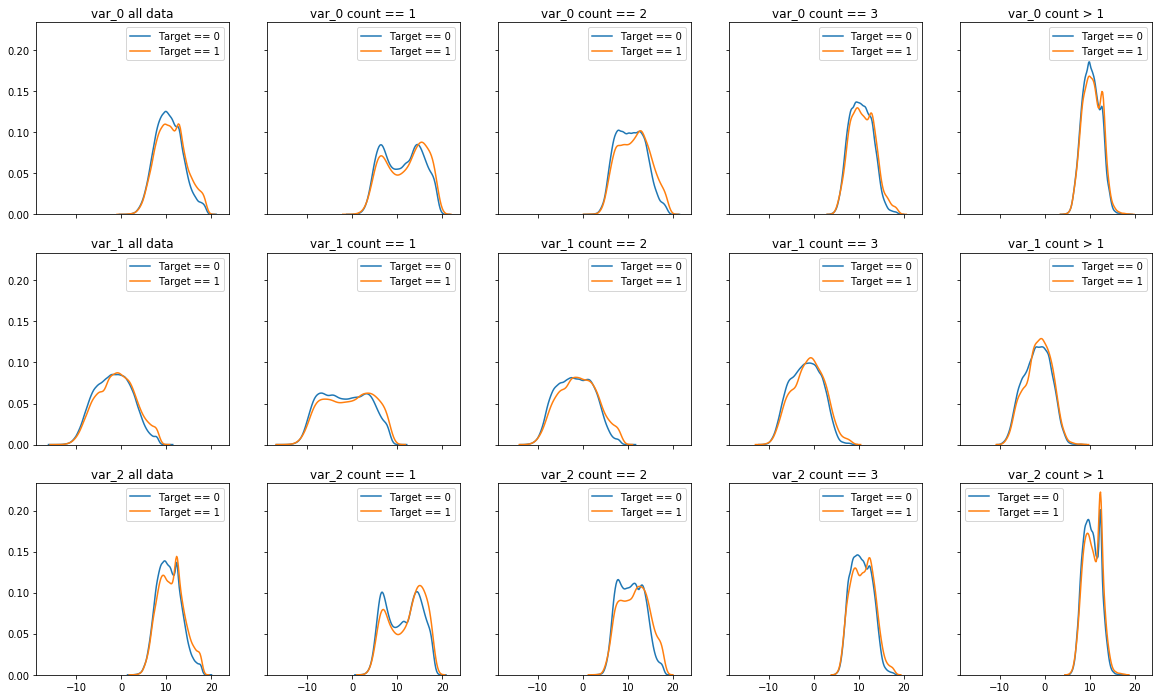

In [5]:
train = train_pd
fig, axs = plt.subplots(3,5, figsize=(20, 12),sharex=True,sharey=True)
target_mask = train['target'] == 1
non_target_mask = train['target'] == 0 

for c,col in enumerate(['var_0','var_1','var_2']):
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    sns.kdeplot(train.loc[non_target_mask, col], ax=axs[c,0], label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=axs[c,0], label='Target == 1')
    axs[c,0].set_title('%s all data'%col)

for c,col in enumerate(['var_0','var_1','var_2']):
    for i in range(1,4):
        train = train_pd.copy()
        train = train[train['%s_count'%col]==i]
        target_mask = train['target'] == 1
        non_target_mask = train['target'] == 0 
        statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
        sns.kdeplot(train.loc[non_target_mask, col], ax=axs[c,i], label='Target == 0')
        sns.kdeplot(train.loc[target_mask, col], ax=axs[c,i], label='Target == 1')
        axs[c,i].set_title('%s count == %d'%(col,i))

for c,col in enumerate(['var_0','var_1','var_2']):
    train = train_pd.copy()
    train = train[train['%s_count'%col]>i]
    target_mask = train['target'] == 1
    non_target_mask = train['target'] == 0 
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    sns.kdeplot(train.loc[non_target_mask, col], ax=axs[c,4], label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=axs[c,4], label='Target == 1')
    axs[c,4].set_title('%s count > 1'%(col))

### Add new features by removing count==1 group

In [6]:
%%time
for i in range(200):
    col = 'var_%d'%i
    mask = train_pd['%s_count'%col]>1
    train_pd.loc[mask,'%s_gt1'%col] = train_pd.loc[mask,col]

CPU times: user 24min 57s, sys: 6min 11s, total: 31min 8s
Wall time: 1min 18s


### Train and validation split

In [7]:
train,valid = train_pd[:-10000],train_pd[-10000:]

In [8]:
x_train = train.drop(['target','ID_code'],axis=1)
y_train = train['target']
x_valid = valid.drop(['target','ID_code'],axis=1)
y_valid = valid['target']

### XGB training

In [9]:
%%time
xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'max_depth': 1, 
            'nthread':16,
            'eta':0.1,
            'silent':1,
            'subsample':0.5,
            'colsample_bytree': 0.05,  
            'eval_metric':'auc',
}
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

CPU times: user 12 s, sys: 4.59 s, total: 16.6 s
Wall time: 2.71 s


In [10]:
%%time

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(xgb_params, dtrain=dtrain,
                num_boost_round=10000,evals=watchlist,
                early_stopping_rounds=30,maximize=True,
                verbose_eval=1000)
yp = clf.predict(dvalid)

[0]	eval-auc:0.538054	train-auc:0.532187
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 30 rounds.
[1000]	eval-auc:0.890076	train-auc:0.901494
[2000]	eval-auc:0.903824	train-auc:0.917398
[3000]	eval-auc:0.909546	train-auc:0.923502
[4000]	eval-auc:0.911292	train-auc:0.926421
[5000]	eval-auc:0.912161	train-auc:0.928418
[6000]	eval-auc:0.91255	train-auc:0.930075
[7000]	eval-auc:0.912669	train-auc:0.931478
[8000]	eval-auc:0.912334	train-auc:0.932688
[9000]	eval-auc:0.911981	train-auc:0.933868
[9999]	eval-auc:0.911624	train-auc:0.934867
CPU times: user 2h 21min 53s, sys: 2min 26s, total: 2h 24min 20s
Wall time: 9min 2s


plot top10 important features


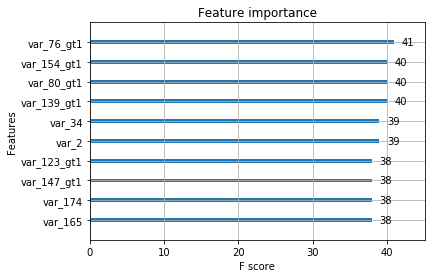

In [11]:
import matplotlib.pyplot as plt
print('plot top10 important features')
xgb.plot_importance(clf,max_num_features=10)
plt.show()